In [558]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import pandas as pd

In [559]:
def find_first_nonzero_slices(image):
    """
    Finds the first slice index with non-zero data along each axis.
    
    Parameters:
        image (numpy.ndarray): 3D image array.
    
    Returns:
        dict: Dictionary with the first non-zero slice indices for each axis.
    """
    first_nonzero_slices = {}
    
    # Iterate over each axis (0, 1, 2)
    for axis in range(image.ndim):
        # Sum along the other two axes to collapse the image along the current axis
        projection = np.any(image > 0, axis=tuple(i for i in range(image.ndim) if i != axis))
        
        # Find the first non-zero slice along the current axis
        first_nonzero_slices[f"Axis {axis}"] = np.argmax(projection)
    
    return first_nonzero_slices

In [560]:
def find_last_nonzero_slices(image):
    """
    Finds the last slice index with non-zero data along each axis.

    Parameters:
        image (numpy.ndarray): 3D image array.

    Returns:
        dict: Dictionary with the last non-zero slice indices for each axis.
    """
    last_nonzero_slices = {}
    for axis in range(image.ndim):
        # Sum along the other axes to collapse the image along the current axis
        projection = np.any(image > 0, axis=tuple(i for i in range(image.ndim) if i != axis))
        
        # Find the last non-zero slice along the current axis
        last_nonzero_slices[f"Axis {axis}"] = len(projection) - 1 - np.argmax(projection[::-1])
    
    return last_nonzero_slices

In [561]:
%cd /Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation

/Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation


/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [562]:
from src.utils.helpers import load_nifti, save_nifti, calculate_dice_score
from src.utils.preprocessing import remove_slices, scale_to_8bit, apply_clahe_to_roi
from src.utils.visualzation import analyze_image

In [563]:
data_path = './Data/SPM/Input'
set_name = 'Training_Set'
img_num = 'IBSR_03'

In [564]:
fixed_image_path = os.path.join(data_path, set_name, img_num, f"m{img_num}.nii")
ground_truth_path = os.path.join(data_path, set_name, img_num, f"{img_num}_seg.nii")

In [565]:
fixed_image_path

'./Data/SPM/Input/Training_Set/IBSR_03/mIBSR_03.nii'

In [566]:
fixed_image, fixed_affine = load_nifti(fixed_image_path)
ground_truth, _ = load_nifti(ground_truth_path) if set_name != 'Test_Set' else (None, None)

In [567]:
fixed_image.shape

(256, 128, 256)

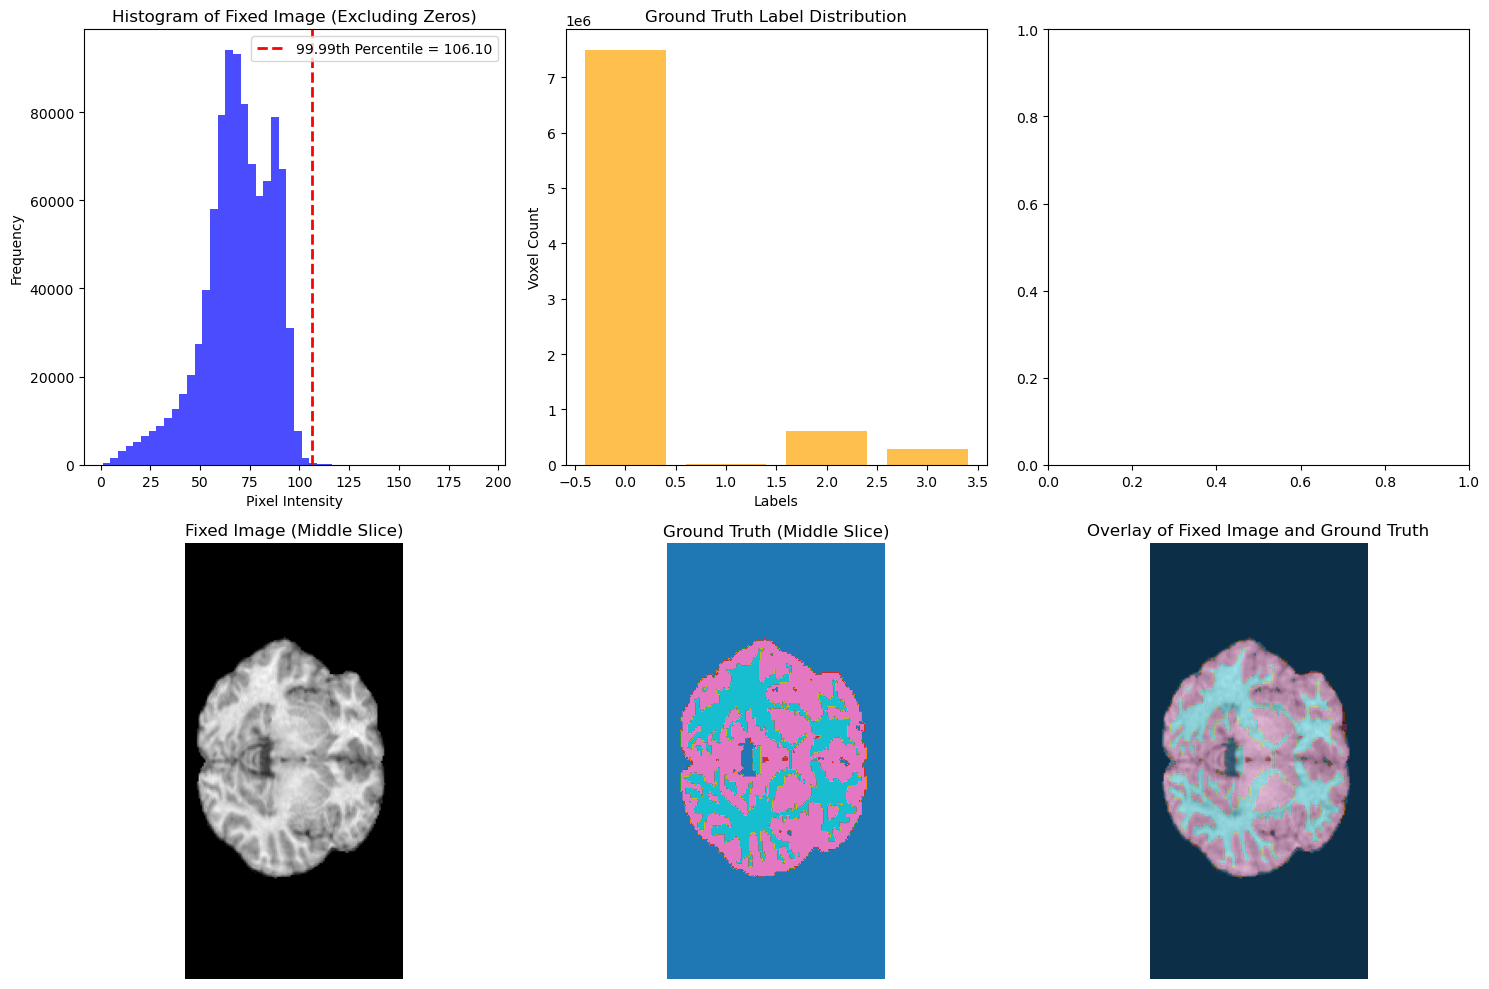

Fixed Image Statistics:
Min: 0.0
Min (Excluding Zeros): 1.0169334411621094
Max: 193.55198669433594
Image Type: float64
Intensity Range: (0.0, 193.55198669433594)
Voxel Count (Total): 8388608
Voxel Count (Non-Zero): 951358
99.99th Percentile: 106.10388543472084

Ground Truth Label Distribution:
Label 0.0: 7489032
Label 1.0: 6662
Label 2.0: 605843
Label 3.0: 287071


In [568]:
stats_before = analyze_image(fixed_image, ground_truth)

In [569]:
def compute_image_stats(image, file_name):
    """
    Computes statistics and first non-zero slices for a given image.

    Parameters:
        image (numpy.ndarray): 3D image array.
        file_name (str): Name of the image file.

    Returns:
        dict: Dictionary with statistics and first non-zero slices.
    """
    stats = {}
    
    # Basic statistics
    non_zero_image = image[image > 0]  # Exclude zero values for stats
    stats["Image"] = file_name
    # stats["min"] = np.mean(non_zero_image)
    # stats["Median"] = np.median(non_zero_image)
    # stats["StdDev"] = np.std(non_zero_image)
    stats["Min_0"] = np.min(non_zero_image)
    stats["Min"] = np.min(image)
    stats["Max"] = np.max(non_zero_image)
    # stats["Voxel Count (Total)"] = image.size
    # stats["Voxel Count (Non-Zero)"] = np.count_nonzero(non_zero_image)

    # First non-zero slice indices
    for axis in range(image.ndim):
        projection = np.any(image > 0, axis=tuple(i for i in range(image.ndim) if i != axis))
        stats[f"NonZero(Axis_{axis})"] = np.argmax(projection)
    
    # Last non-zero slice indices
    for axis in range(image.ndim):
        projection = np.any(image > 0, axis=tuple(i for i in range(image.ndim) if i != axis))
        stats[f"LastNonZero(Axis_{axis})"] = len(projection) - 1 - np.argmax(projection[::-1])
        
    return stats

def process_image_folder(folder_path):
    """
    Processes all images in a folder and computes statistics for each image.

    Parameters:
        folder_path (str): Path to the folder containing the images.

    Returns:
        pd.DataFrame: DataFrame containing the stats for all images.
    """
    stats_list = []
    
    for img_name in os.listdir(folder_path):
        if not img_name.startswith("."):
            for file_name in os.listdir(os.path.join(folder_path, img_name)):
                if (file_name.endswith(".nii") or file_name.endswith(".nii.gz")) and file_name.startswith("m") and not file_name.endswith("_seg.nii") and not file_name.endswith("_seg8.mat"):
                    file_path = os.path.join(folder_path, img_name, file_name)
                    
                    # Load the image
                    img = nib.load(file_path)
                    data = img.get_fdata()
                    
                    # Compute stats for the image
                    stats = compute_image_stats(data, file_name)
                    stats_list.append(stats)
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(stats_list)
    return stats_df

In [570]:
data_path = './Data/SPM/Input'
set_name = 'Training_Set'
# Dynamic folder name
folder_path = os.path.join(data_path, set_name)
# Process the folder and get the stats
stats_df = process_image_folder(folder_path)

# # Save the stats to a CSV file (optional)
# output_csv_path = os.path.join(folder_path, "image_stats.csv")
# stats_df.to_csv(output_csv_path, index=False)

# Display the stats
print(stats_df)

          Image     Min_0  Min         Max  NonZero(Axis_0)  NonZero(Axis_1)  \
0  mIBSR_18.nii  4.887664  0.0  150.197357               45                0   
1  mIBSR_16.nii  2.282023  0.0  235.478378               44                4   
2  mIBSR_05.nii  1.044221  0.0  178.304993               58                3   
3  mIBSR_03.nii  1.016933  0.0  193.551987               55                7   
4  mIBSR_04.nii  0.933111  0.0  133.925568               51                3   
5  mIBSR_08.nii  0.940950  0.0  108.923416               60                5   
6  mIBSR_01.nii  2.088974  0.0  198.983582               55                2   
7  mIBSR_06.nii  2.838259  0.0  119.251350               59                2   
8  mIBSR_07.nii  0.936078  0.0   76.402672               61                2   
9  mIBSR_09.nii  2.204050  0.0  150.084030               59                3   

   NonZero(Axis_2)  LastNonZero(Axis_0)  LastNonZero(Axis_1)  \
0               50                  210                

In [571]:
print(f'X_first - {stats_df['NonZero(Axis_0)'].mean()}, Y_first - {stats_df['NonZero(Axis_1)'].mean()}, Z_first - {stats_df['NonZero(Axis_2)'].mean()}')
print(f'X_last - {stats_df['LastNonZero(Axis_0)'].mean()}, Y_last - {stats_df['LastNonZero(Axis_1)'].mean()}, Z_last - {stats_df['LastNonZero(Axis_2)'].mean()}')

X_first - 54.7, Y_first - 3.1, Z_first - 64.9
X_last - 199.0, Y_last - 117.2, Z_last - 205.0


In [572]:
print(f'X_first - {stats_df['NonZero(Axis_0)'].min()}, Y_first - {stats_df['NonZero(Axis_1)'].min()}, Z_first - {stats_df['NonZero(Axis_2)'].min()}')
print(f'X_last - {stats_df['LastNonZero(Axis_0)'].max()}, Y_last - {stats_df['LastNonZero(Axis_1)'].max()}, Z_last - {stats_df['LastNonZero(Axis_2)'].max()}')

X_first - 44, Y_first - 0, Z_first - 50
X_last - 210, Y_last - 120, Z_last - 222


In [573]:
# No. of slices to remove from the start and end = 32
# scale to 99.99th percentile

In [574]:
image_reduced = remove_slices(fixed_image, 0, 32, 32) # remove 32 slices from the top and bottom for x axis
image_reduced = remove_slices(image_reduced, 2, 32, 32) # remove 32 slices from the top and bottom for z axis

ground_truth_reduced = None if ground_truth is None else remove_slices(ground_truth, 0, 32, 32)
ground_truth_reduced = None if ground_truth is None else remove_slices(ground_truth_reduced, 2, 32, 32)

In [575]:
image_scaled = scale_to_8bit(image_reduced)

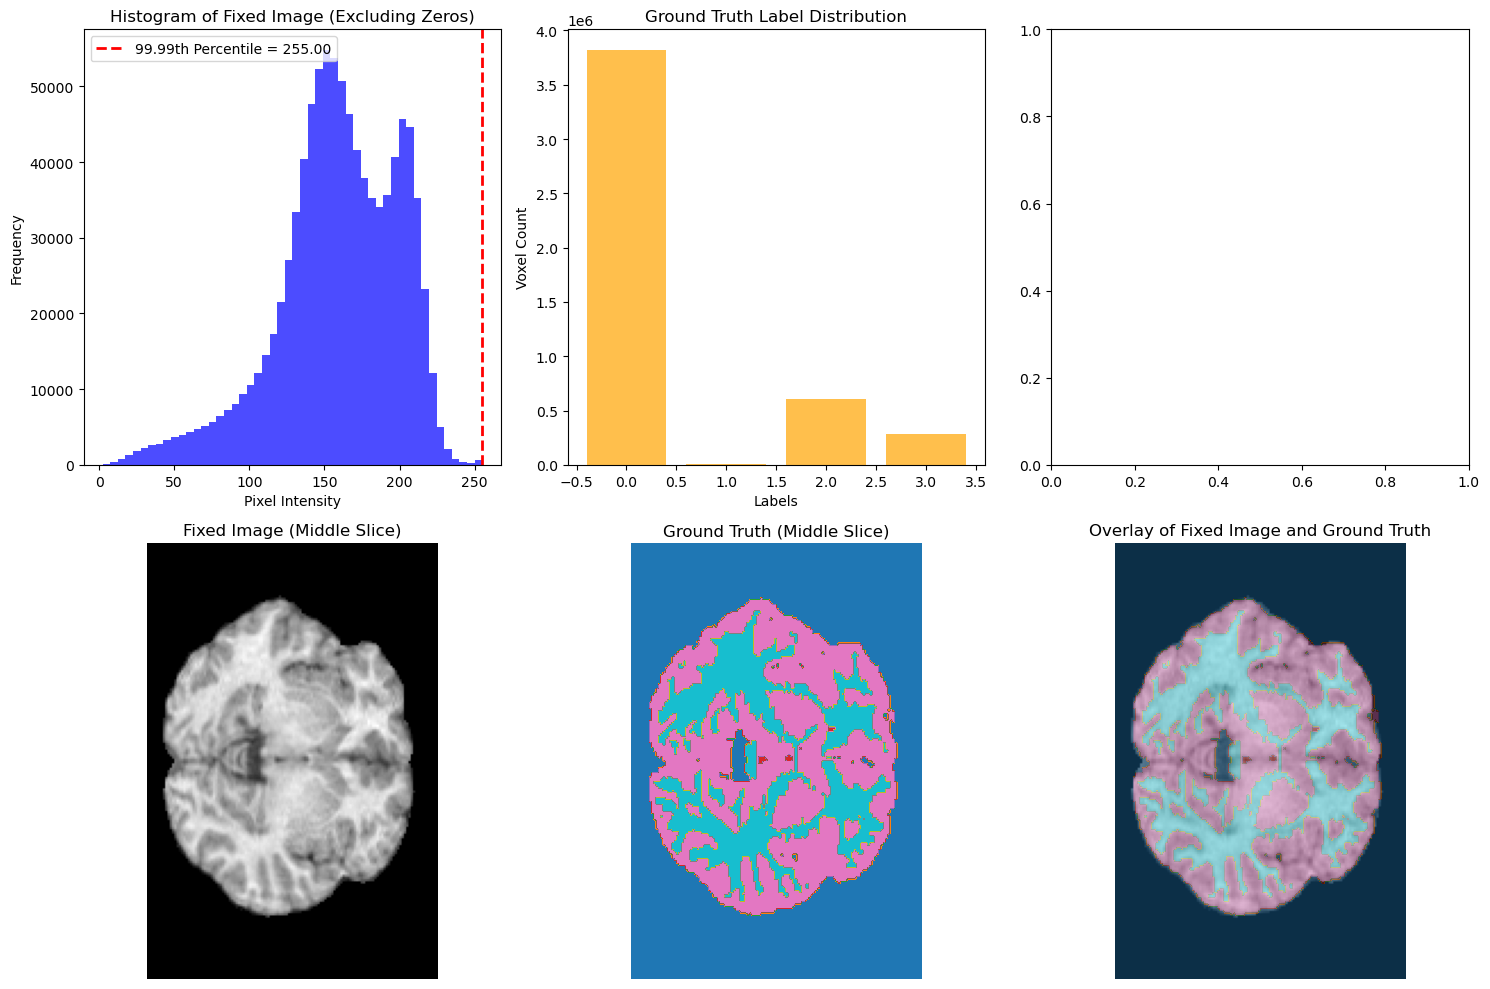

Fixed Image Statistics:
Min: 0.0
Min (Excluding Zeros): 2.3410284923124616
Max: 255.0
Image Type: float64
Intensity Range: (0.0, 255.0)
Voxel Count (Total): 4718592
Voxel Count (Non-Zero): 951358
99.99th Percentile: 254.99845653930453

Ground Truth Label Distribution:
Label 0.0: 3819016
Label 1.0: 6662
Label 2.0: 605843
Label 3.0: 287071


In [576]:
stats_after = analyze_image(image_scaled, ground_truth_reduced)